# Kickstarter Projects

Can we predict which Kickstarter projects will be successful?

## Data Cleaning and Exploration

In [1]:
#import pandas, matplotlib, seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
#read in and preview file
#download path https://www.kaggle.com/toshimelonhead/400000-kickstarter-projects
file_path = 'kickstarter.csv'

data = pd.read_csv(file_path, index_col = 'Unnamed: 0')
print(data.head(1))
data.info()

          id  backers_count  \
0  857125548              1   

                                               blurb currency    goal  \
0  Exploring paint and its place in a digital world.      USD  2000.0   

           launched_at             deadline location.country   name  \
0  2015-03-19 22:34:57  2015-04-30 23:12:00               US  Remix   

   usd_pledged  ... days_to_deadline  goal_USD  category_name  category_slug  \
0         25.0  ...               42    2000.0    Digital Art            art   

  blurb_length  location_type  location_country  location_state  \
0            9           Town                US              NY   

   location_displayable_name  binary_state  
0               New York, NY        failed  

[1 rows x 29 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 430938 entries, 0 to 768
Data columns (total 29 columns):
id                           430938 non-null int64
backers_count                430938 non-null int64
blurb                       

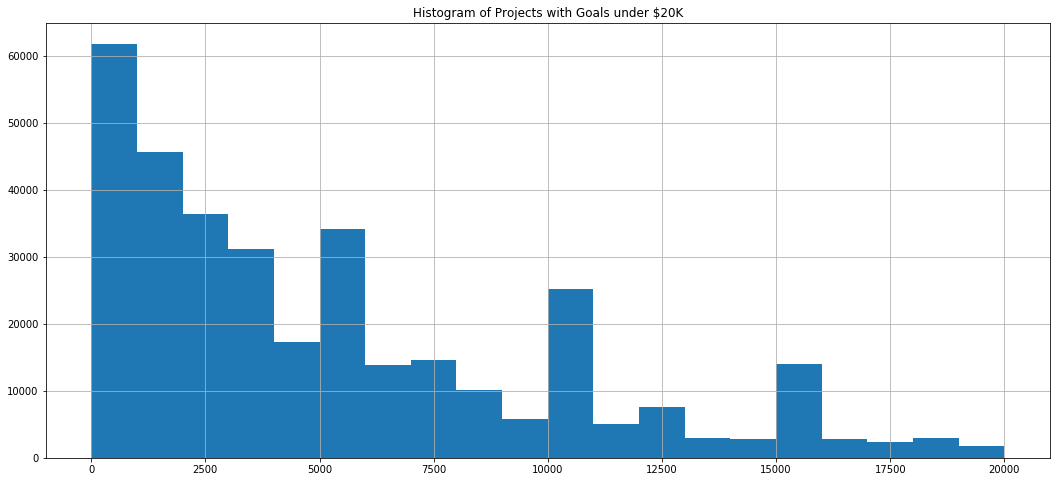

In [4]:
#attempt to understand goal_USD data shape by only looking at data under 20k
data['goal_USD'].loc[data['goal_USD'] < 20000].hist(bins = 20, figsize=(18,8))
plt.title('Histogram of Projects with Goals under $20K')
plt.show()

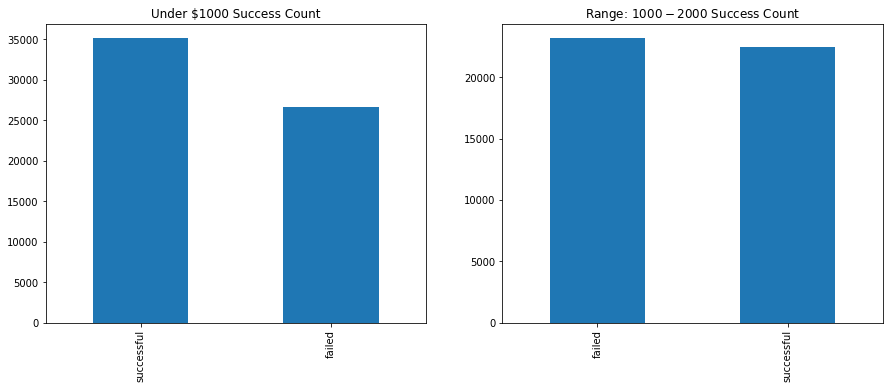

In [5]:
#Checking first 1000 category against 2nd 1000. Already by the second, failure is more likely than success.
fig=plt.figure(figsize=(15,5.5))
plt.subplot(1,2,1)
plt.title('Under $1000 Success Count')
data['binary_state'].loc[data['goal_USD'] < 1000].value_counts().plot(kind='bar')
plt.subplot(1,2,2)
plt.title("Range: $1000 - $2000 Success Count")
data['binary_state'][(data['goal_USD'] >= 1000) & (data['goal_USD'] < 2000)].value_counts().plot(kind='bar')
plt.show()


I decided to throw out data with a goal under $1000 as they do not seem to be "serious" crowdfunding projects.

In [6]:
#throwing data with a goal under 1000
cleaned_data = data.loc[data['goal_USD'] >= 1000]

In [7]:
#print out approximate time when data was captured
print(cleaned_data['launched_at'].max())
#filter out data where target date is beyond the date of the data
cleaned_data = cleaned_data.loc[cleaned_data['deadline'] <= cleaned_data['launched_at'].max()]

2019-04-18 04:49:38


I threw out data where the deadline is beyond the cutoff date

In [8]:
#convert binary outcome to boolean
cleaned_data['outcome'] = [(i == 'successful') for i in cleaned_data['binary_state']]

## Is ID an appropriate Index?

In [9]:
#is ID an appropriate index?
cleaned_data.id.nunique()

267679

ID is not an appropriate index as there are many duplicates

In [10]:
#look at some duplicated ID values
cleaned_data[cleaned_data.id.duplicated(keep=False)].sort_values('id').head(7)

,id,backers_count,blurb,currency,goal,launched_at,deadline,location.country,name,usd_pledged,...,goal_USD,category_name,category_slug,blurb_length,location_type,location_country,location_state,location_displayable_name,binary_state,outcome
3619,8624,737,A compact outdoor cooking set that you can use...,EUR,30000.0,2018-02-22 09:44:29,2018-03-29 08:44:29,US,Kombuis a portable and efficient rocket stove ...,93005.594341,...,36966.2991,Product Design,design,12,Town,US,WV,"Belgium, WV",successful,True
865,8624,499,A compact outdoor cooking set that you can use...,EUR,30000.0,2018-02-22 09:44:29,2018-03-29 08:44:29,US,Kombuis a portable and efficient rocket stove ...,59989.760404,...,36966.2991,Product Design,design,12,Town,US,WV,"Belgium, WV",successful,True
1446,8624,498,A compact outdoor cooking set that you can use...,EUR,30000.0,2018-02-22 09:44:29,2018-03-29 08:44:29,US,Kombuis a portable and efficient rocket stove ...,59871.468247,...,36966.2991,Product Design,design,12,Town,US,WV,"Belgium, WV",successful,True
2753,18520,2,Raising money to help my grandmother recover f...,USD,15000.0,2016-10-19 13:32:40,2016-11-18 14:32:40,US,Grandma's are Life,11.000000,...,15000.0000,World Music,music,24,Town,US,OH,"Cleveland, OH",failed,False
3348,18520,4,Raising money to help my grandmother recover f...,USD,15000.0,2016-10-19 13:32:40,2016-11-18 14:32:40,US,Grandma's are Life,62.000000,...,15000.0000,World Music,music,24,Town,US,OH,"Cleveland, OH",failed,False
3511,38736,3,All your herbal tea remedies here. From colds ...,USD,2500.0,2018-08-22 03:51:56,2018-10-21 03:51:56,US,Herbal Teas,96.000000,...,2500.0000,Drinks,food,21,Town,US,NY,"Livonia, NY",failed,False
3006,38736,3,All your herbal tea remedies here. From colds ...,USD,2500.0,2018-08-22 03:51:56,2018-10-21 03:51:56,US,Herbal Teas,96.000000,...,2500.0000,Drinks,food,21,Town,US,NY,"Livonia, NY",failed,False


The same projects are captured at different points in time, I will remove duplicate ID lines taking information from the most recent information (highest USD pledged)

In [11]:
#dropping duplicates, note sorting by usd pledged so I only keep the most recent data (unlikely pledged amount goes down)
cleaned_data = cleaned_data.sort_values('usd_pledged', ascending = False).drop_duplicates(subset = 'id', keep = 'first')
cleaned_data.id.nunique()

267679

ID is now a unique column, so it can be set as the index

In [12]:
#drop old index and replace with ID column
cleaned_data = cleaned_data.reset_index(drop=True).set_index('id').sort_index()

## Date Time Columns

In [13]:
#create a new column for days between launch and goal date
cleaned_data['launched_at'] = pd.to_datetime(cleaned_data['launched_at'])
cleaned_data['deadline'] = pd.to_datetime(cleaned_data['deadline'])
cleaned_data['days_between'] = (cleaned_data['deadline'] - cleaned_data['launched_at']).dt.days

## Looking at Text Columns (blurb and name)

In [14]:
#looking for help as the first word in the blurb
cleaned_data['help_first_blurb'] = [('help' == str(i)[0:4].lower()) for i in cleaned_data.blurb]
print(cleaned_data.help_first_blurb.value_counts())
print((cleaned_data['help_first_blurb'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['help_first_blurb'].value_counts()))

False    260978
True       6701
Name: help_first_blurb, dtype: int64
False    0.430347
True     0.562006
Name: help_first_blurb, dtype: float64


Highlighting the purpose of helping someone is helpful for success.

In [44]:
#looking for luxury in blurb
cleaned_data['luxury_blurb'] = ['luxury' in str(i).lower() for i in cleaned_data.blurb]
print(cleaned_data.luxury_blurb.value_counts())
print((cleaned_data['luxury_blurb'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['luxury_blurb'].value_counts()))
#luxury doesn't appear that often
cleaned_data.drop(['luxury_blurb'], axis = 1, inplace = True)

False    266872
True        807
Name: luxury_blurb, dtype: int64
False    0.433744
True     0.400248
Name: luxury_blurb, dtype: float64


Luxury did not appear often in blurb

In [46]:
#looking for family in blurb
cleaned_data['family_blurb'] = ['family' in str(i).lower() for i in cleaned_data.blurb]
print(cleaned_data.family_blurb.value_counts())
print((cleaned_data['family_blurb'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['family_blurb'].value_counts()))

#removing
cleaned_data.drop(['family_blurb'], axis = 1, inplace = True)

False    263225
True       4454
Name: family_blurb, dtype: int64
False    0.434168
True     0.402559
Name: family_blurb, dtype: float64


The word family in blurb was correlated with slightly less success. I decided to remove the variable

In [15]:
#check if the first word of the blurb or name is lowercase
def lowercase_first(row):
    y = ((str(row['blurb'])[0:2].islower()) and (str(row['blurb'])[0:2].isalpha()) or ((str(row['name'])[0:2].islower()) and (str(row['name'])[0:2].isalpha())))
    return y

cleaned_data['lowercase_first'] = cleaned_data.apply(lowercase_first, axis=1)

print(cleaned_data.lowercase_first.value_counts())
print((cleaned_data['lowercase_first'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['lowercase_first'].value_counts()))

False    261795
True       5884
Name: lowercase_first, dtype: int64
False    0.436716
True     0.296907
Name: lowercase_first, dtype: float64


Lack of capitalization might indicate informality or lack of attention to detail.

In [408]:
#check if the the first word of the name is all capitalized
cleaned_data['first_name_cap'] = [(str(i)[0:2].isupper()) and (str(i)[0:2].isalpha()) for i in cleaned_data.name]
print(cleaned_data.first_name_cap.value_counts())
print((cleaned_data['first_name_cap'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['first_name_cap'].value_counts()))

#check if the the first word of the blurb is capitalized wasn't as impactful

False    236085
True      31594
Name: first_name_cap, dtype: int64
False    0.426715
True     0.485409
Name: first_name_cap, dtype: float64


Those projects capitalizing the first word of the name had a slightly higher probability of success.

In [409]:
#first character in name being a non-alphabet character was not impactful

#does the blurb contain an exclamation point? Does the name?

cleaned_data['blurb_exclam'] = [("!" in str(i)) for i in cleaned_data.blurb]
print(cleaned_data.blurb_exclam.value_counts())
print((cleaned_data['blurb_exclam'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['blurb_exclam'].value_counts()))

cleaned_data['name_exclam'] = [("!" in str(i)) for i in cleaned_data.name]
print(cleaned_data.name_exclam.value_counts())
print((cleaned_data['name_exclam'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['name_exclam'].value_counts()))


False    206101
True      61578
Name: blurb_exclam, dtype: int64
False    0.418246
True     0.485173
Name: blurb_exclam, dtype: float64
False    243895
True      23784
Name: name_exclam, dtype: int64
False    0.426503
True     0.506853
Name: name_exclam, dtype: float64


In [23]:
#count the length of the name
cleaned_data['name_length'] = [len(str(i).split()) for i in cleaned_data.name]

## Additional Cleaning (Dropping Columns)

In [24]:
#confirm staff_pick and spotlight highly correlated with success
print("The proportion of projects that are a staff pick: " + str(round(cleaned_data.staff_pick.mean(), 3)) + ".")
print("The proportion of projects that are a staff pick successful are: " + str(round(cleaned_data.outcome.loc[cleaned_data.staff_pick == True].mean(), 3)) + ".")
print("")
print("The proportion of projects that are spotlighted: " + str(round(cleaned_data.spotlight.mean(), 3)) + ".")
print("The proportion of projects that are spotlighted and successful: " + str(round(cleaned_data.outcome.loc[cleaned_data.spotlight == True].mean(), 3)) + ".")

The proportion of projects that are a staff pick: 0.12.
The proportion of projects that are a staff pick successful are: 0.837.

The proportion of projects that are spotlighted: 0.429.
The proportion of projects that are spotlighted and successful: 1.0.


In [25]:
# dropping the location.country column (already location_country column); 
# the days to deadline not useful as the deadline should be passed;
# the state column is not necessary with the outcome column; and the individual date columns are not necessary
# the spotlight and staff pick columns can be dropped

cleaned_data = cleaned_data.drop(columns=['location.country', 'days_to_deadline', 'state', 
                                 'year', 'month', 'day', 'hour', 'spotlight', 'staff_pick'])

Dropping unnecessary columns

In [26]:
#looking at info of cleaning data
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267679 entries, 8624 to 2147476221
Data columns (total 24 columns):
backers_count                267679 non-null int64
blurb                        267679 non-null object
currency                     267679 non-null object
goal                         267679 non-null float64
launched_at                  267679 non-null datetime64[ns]
deadline                     267679 non-null datetime64[ns]
name                         267676 non-null object
usd_pledged                  267679 non-null float64
slug                         267679 non-null object
static_usd_rate              267679 non-null float64
goal_USD                     267679 non-null float64
category_name                267679 non-null object
category_slug                267679 non-null object
blurb_length                 267679 non-null int64
location_type                267679 non-null object
location_country             267679 non-null object
location_state               267

In [27]:
#examining data lines for more insights on keywords
cleaned_data.head(10)

,backers_count,blurb,currency,goal,launched_at,deadline,name,usd_pledged,slug,static_usd_rate,...,location_type,location_country,location_state,location_displayable_name,binary_state,outcome,days_between,help_first_blurb,lowercase_first,name_length
id,,,,,,,,,,,,,,,,,,,,,
8624,737,A compact outdoor cooking set that you can use...,EUR,30000.0,2018-02-22 09:44:29,2018-03-29 08:44:29,Kombuis a portable and efficient rocket stove ...,93005.594341,kombuis-a-portable-and-efficient-rocket-stove-...,1.232210,...,Town,US,WV,"Belgium, WV",successful,True,34,False,False,10
18520,4,Raising money to help my grandmother recover f...,USD,15000.0,2016-10-19 13:32:40,2016-11-18 14:32:40,Grandma's are Life,62.000000,grandmas-are-life,1.000000,...,Town,US,OH,"Cleveland, OH",failed,False,30,False,False,3
24380,18,A sanctuary for humans and felines alike! Come...,USD,20000.0,2015-10-27 15:25:33,2015-11-26 16:25:33,Puss N' Books: A relaxing cat cafe and bookstore.,776.000000,puss-n-books-a-relaxing-cat-cafe-and-bookstore,1.000000,...,Zip,US,IL,"Bloomington, IL",failed,False,30,False,False,9
33867,42,Taste Makers is a socially conscious brand tha...,CAD,18000.0,2015-06-15 18:28:11,2015-07-30 18:28:11,TASTE MAKERS BY TRISH P,2271.723453,taste-makers-by-trish-p,0.811910,...,Town,CA,BC,"Vancouver, Canada",failed,False,45,False,False,5
38736,3,All your herbal tea remedies here. From colds ...,USD,2500.0,2018-08-22 03:51:56,2018-10-21 03:51:56,Herbal Teas,96.000000,herbal-teas,1.000000,...,Town,US,NY,"Livonia, NY",failed,False,60,False,False,2
39036,68,"The BEST beef sticks, beef jerky and signature...",USD,2500.0,2016-05-16 22:34:18,2016-06-30 22:34:18,The Meat Candy Experience,3239.000000,the-meat-candy-experience,1.000000,...,Town,US,WI,"Kronenwetter, WI",successful,True,45,False,False,4
39235,338,"4tec is a classic 4 in a row table top game, r...",EUR,5000.0,2018-09-10 06:48:50,2018-10-10 06:48:50,4tec: a New 3D Connect 4 Game,15440.032893,4tec-a-new-3d-connect-4-game,1.156384,...,Town,IE,Dublin,"Dublin, Ireland",successful,True,30,False,False,7
39409,66,CalArts thesis film inspired by true events su...,USD,10500.0,2011-07-20 19:28:17,2011-08-19 19:28:17,WHILE THE TREES SLEEP,11545.000000,while-the-trees-sleep,1.000000,...,Town,US,MO,"Columbia, MO",successful,True,30,False,False,4
46588,171,A Musical Lightning Storm. Get struck by light...,USD,20000.0,2015-07-15 17:36:09,2015-08-08 04:44:00,Orage: Interactive Lightning Experience at Bur...,21563.000000,orage-interactive-lightning-experience-at-burning,1.000000,...,Town,US,NV,"Black Rock City, NV",successful,True,23,False,False,8


## Data Visualization

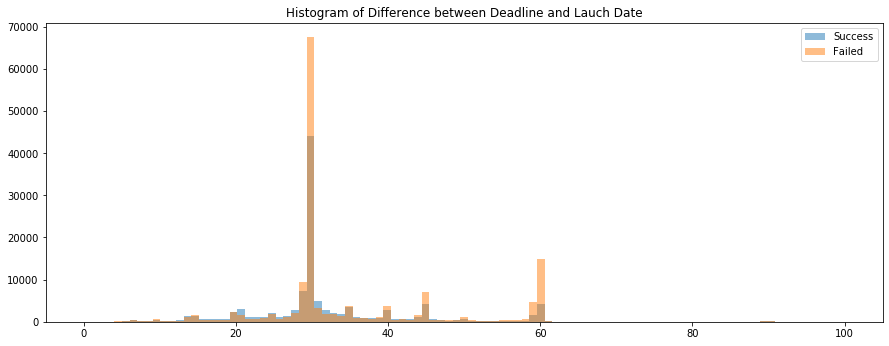

Success Descriptive Statistics
count    116077.000000
mean         32.571026
std          11.202154
min           1.000000
25%          29.000000
50%          30.000000
75%          34.000000
max          91.000000
Name: days_between, dtype: float64

Failed Descriptive Statistics
count    151602.000000
mean         35.480818
std          12.632391
min           1.000000
25%          30.000000
50%          30.000000
75%          40.000000
max          92.000000
Name: days_between, dtype: float64


In [28]:
#histogram of days between
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['days_between'].loc[cleaned_data['outcome'] == True]
y = cleaned_data['days_between'].loc[cleaned_data['outcome'] == False]
bins = np.linspace(0, 100, 100)

plt.hist(x, bins, alpha=0.5, label='Success')
plt.hist(y, bins, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
plt.title('Histogram of Difference between Deadline and Lauch Date')
plt.show()

print("Success Descriptive Statistics")
print(x.describe())
print('')
print("Failed Descriptive Statistics")
print(y.describe())

Most Kickstarters have the deadline set at around 30 days from the launch date.

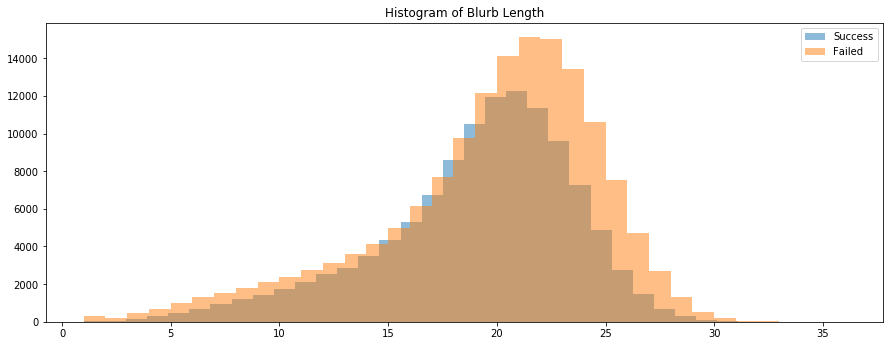

Success Descriptive Statistics
count    116077.000000
mean         19.114191
std           4.650033
min           1.000000
25%          17.000000
50%          20.000000
75%          22.000000
max          35.000000
Name: blurb_length, dtype: float64

Failed Descriptive Statistics
count    151602.000000
mean         19.188309
std           5.132148
min           1.000000
25%          17.000000
50%          20.000000
75%          23.000000
max          36.000000
Name: blurb_length, dtype: float64


In [50]:
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['blurb_length'].loc[cleaned_data['outcome'] == True]
y = cleaned_data['blurb_length'].loc[cleaned_data['outcome'] == False]

plt.hist(x, bins=35, alpha=0.5, label='Success')
plt.hist(y, bins=35, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
plt.title('Histogram of Blurb Length')
plt.show()
print("Success Descriptive Statistics")
print(x.describe())
print('')
print("Failed Descriptive Statistics")
print(y.describe())

Both successful and unsuccessful projects have a similar blurb length distribution

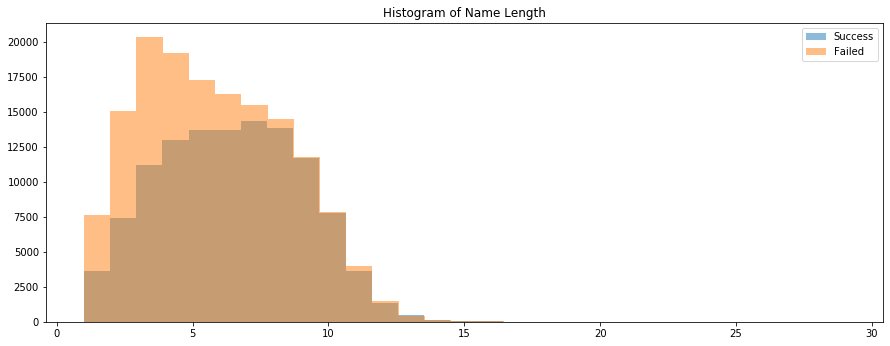

Success Descriptive Statistics
count    116077.000000
mean          6.162177
std           2.716849
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          27.000000
Name: name_length, dtype: float64

Failed Descriptive Statistics
count    151602.000000
mean          5.533878
std           2.782241
min           1.000000
25%           3.000000
50%           5.000000
75%           8.000000
max          29.000000
Name: name_length, dtype: float64


In [51]:
fig=plt.figure(figsize=(15,5.5))
x = cleaned_data['name_length'].loc[cleaned_data['outcome'] == True]
y = cleaned_data['name_length'].loc[cleaned_data['outcome'] == False]

plt.hist(x, bins=27, alpha=0.5, label='Success')
plt.hist(y, bins=29, alpha=0.5, label='Failed')
plt.legend(loc='upper right')
plt.title('Histogram of Name Length')
plt.show()
print("Success Descriptive Statistics")
print(x.describe())
print('')
print("Failed Descriptive Statistics")
print(y.describe())

Longer blurbs were more likely to be successful on average. There is a high concentration of failures in the 1-4 name length range compared with the more uniform distribution of successes.

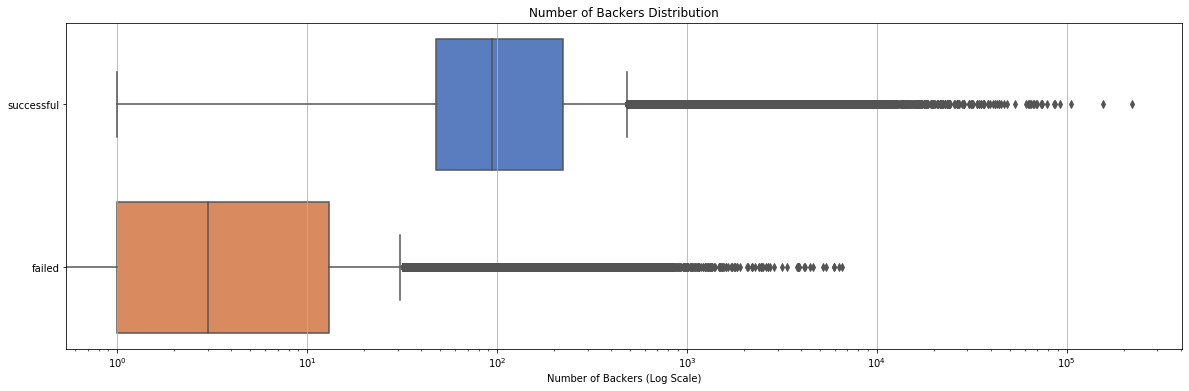

In [31]:
#looking distribution of the backers_count column
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="backers_count", y = 'binary_state', data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Number of Backers (Log Scale)", title = 'Number of Backers Distribution')
plt.show()

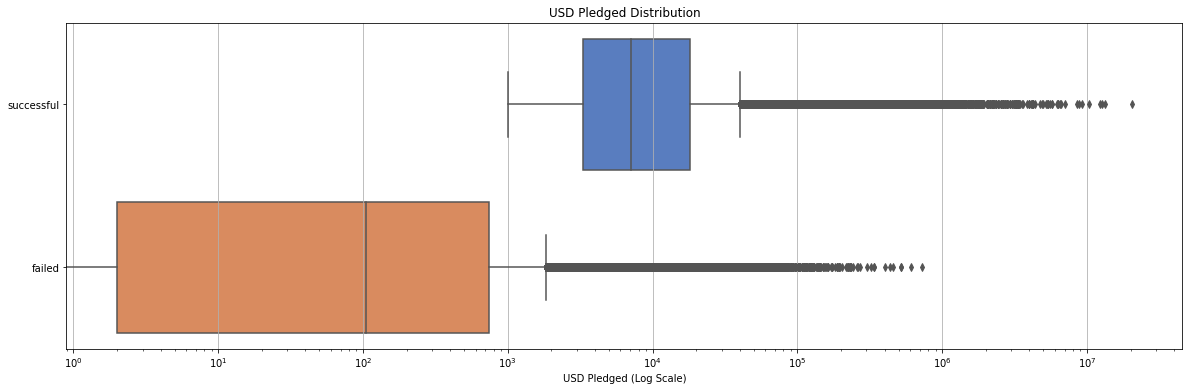

In [32]:
#looking at distribution of USD Pledged
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="usd_pledged", y="binary_state", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "USD Pledged (Log Scale)", title = 'USD Pledged Distribution')
plt.show()

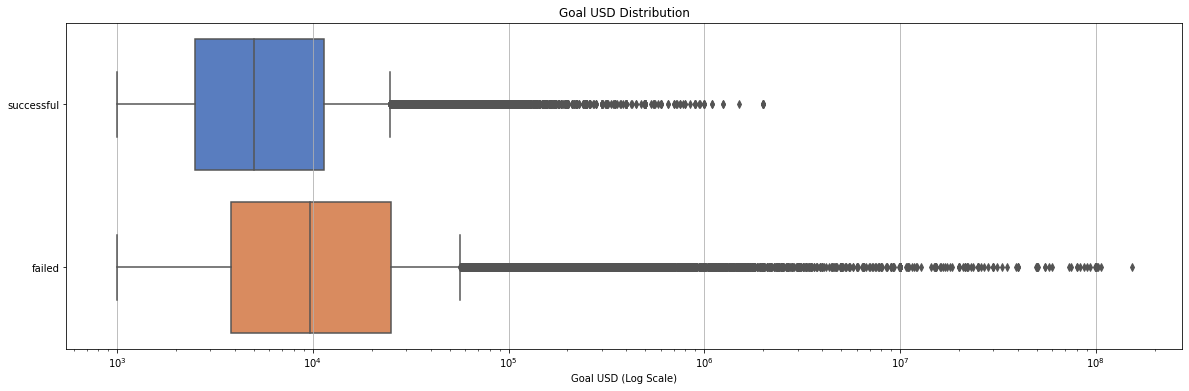

In [33]:
#looking at distribution of USD Goal
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xscale("log")
sns.boxplot(x="goal_USD", y="binary_state", data=cleaned_data, palette = 'muted')
ax.xaxis.grid(True)
ax.set(ylabel="", xlabel = "Goal USD (Log Scale)", title = 'Goal USD Distribution')
plt.show()

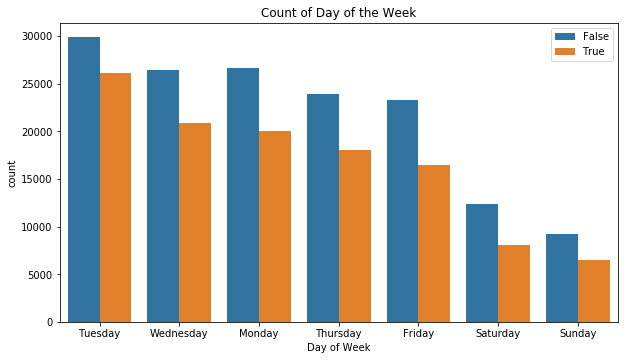

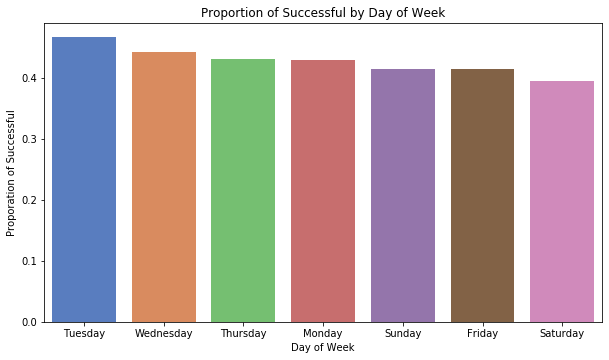

In [34]:
#day of the week bar chart
# https://seaborn.pydata.org/generated/seaborn.countplot.html interesting information
cleaned_data['day_week'] = cleaned_data['launched_at'].dt.day_name()
fig=plt.figure(figsize=(10,5.5))
chart = sns.countplot(x = 'day_week', hue = 'outcome', data = cleaned_data, order = cleaned_data['day_week'].value_counts().index)
plt.xlabel('Day of Week')
plt.legend(title = '')
plt.title('Count of Day of the Week')
plt.show()
#probability distribution
y = (cleaned_data['day_week'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['day_week'].value_counts())
y = y.sort_values(ascending=False)
fig=plt.figure(figsize=(10,5.5))
ax = sns.barplot(x = y.index, y = y, palette = 'muted')
plt.xlabel('Day of Week')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Day of Week')
plt.show()

The middle of the week is the most popular launch time and has the higest probability of success.

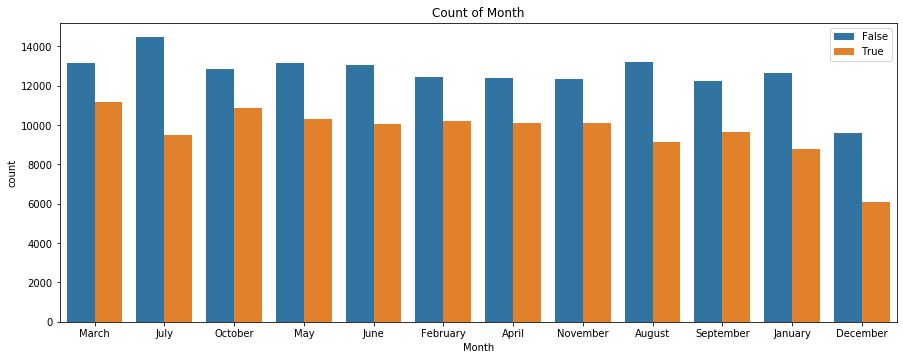

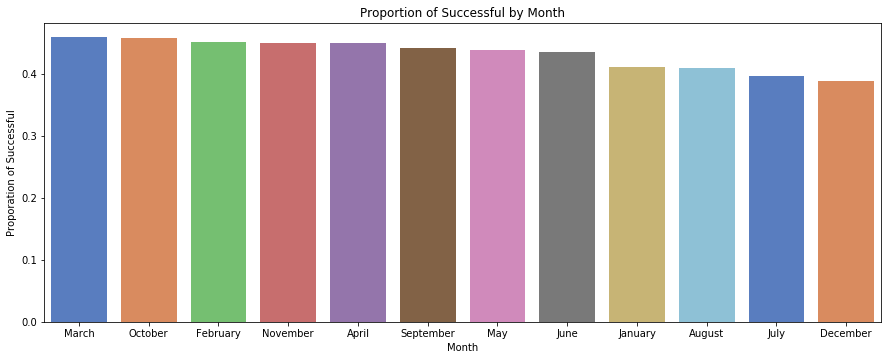

In [35]:
#month of launch count plot
cleaned_data['month'] = cleaned_data['launched_at'].dt.month_name()
fig=plt.figure(figsize=(15,5.5))
chart = sns.countplot(x = 'month', hue = 'outcome', data = cleaned_data, order = cleaned_data['month'].value_counts().index)
plt.xlabel('Month')
plt.legend(title = '')
plt.title('Count of Month')
plt.show()
y = (cleaned_data['month'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['month'].value_counts())
y = y.sort_values(ascending=False)
fig=plt.figure(figsize=(15,5.5))
ax = sns.barplot(x = y.index, y = y, palette = 'muted')
plt.xlabel('Month')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Month')
plt.show()

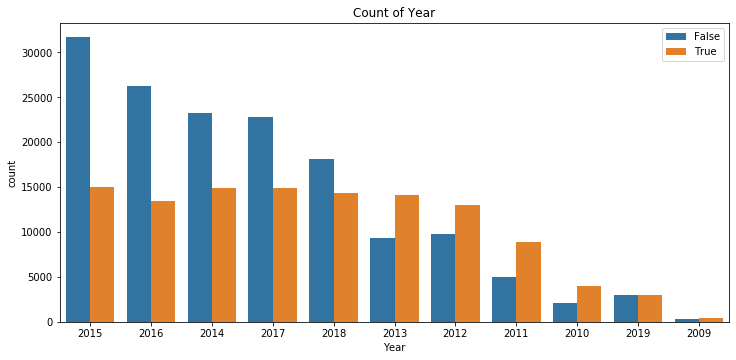

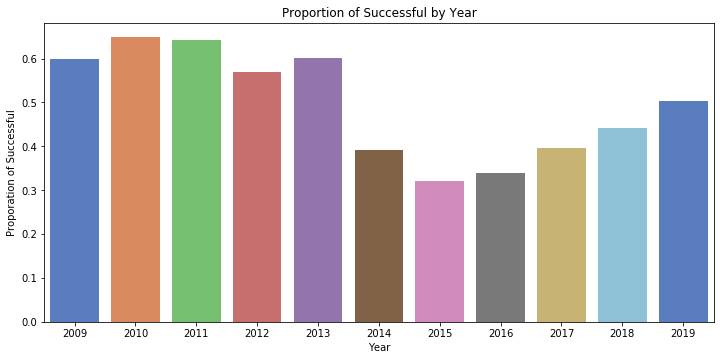

In [36]:
#year of launch count plot
cleaned_data['year'] = cleaned_data['launched_at'].dt.year
fig=plt.figure(figsize=(12,5.5))
chart = sns.countplot(x = 'year', hue = 'outcome', data = cleaned_data, order = cleaned_data['year'].value_counts().index)
plt.xlabel('Year')
plt.legend(title = '')
plt.title('Count of Year')
plt.show()
y = (cleaned_data['year'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['year'].value_counts())
fig=plt.figure(figsize=(12,5.5))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Year')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Year')
plt.show()

Note that 2019 data is not for a full year. Has the success rate changed in a predicatible pattern?

It appear that the early years were most successful with a large drop in 2014 and then it eventually began to rebound.

**What happened in 2014?**

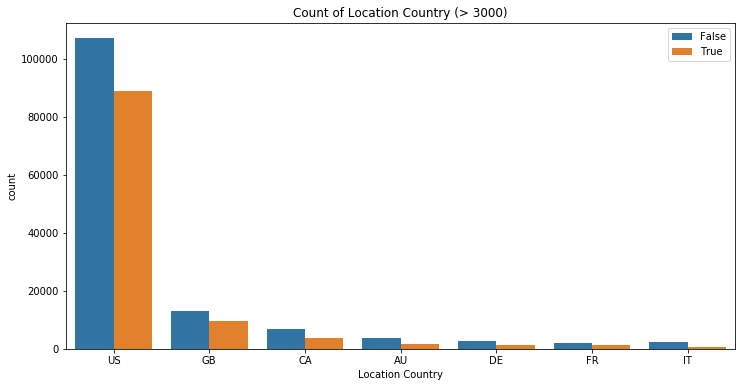

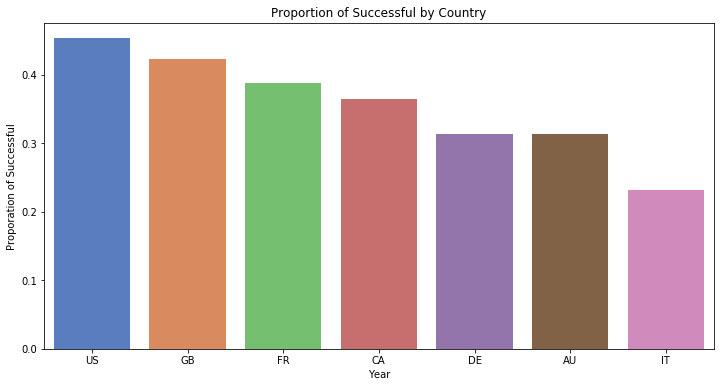

US    0.453163
GB    0.422417
FR    0.387234
CA    0.364167
DE    0.313262
AU    0.312783
IT    0.232066
Name: location_country, dtype: float64


In [37]:
#show the frequency of location country for those with at least 5000 occurrences
fig = plt.figure(figsize = (12, 6))
sns.countplot(x = 'location_country', hue = 'outcome', 
              data = cleaned_data[cleaned_data.location_country.isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])], 
              order = cleaned_data.location_country.loc[cleaned_data.location_country.isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])].value_counts().index)
plt.legend(title ='')
plt.xlabel('Location Country')
plt.title('Count of Location Country (> 3000)')
plt.show()
# make this into a probability distribution like above
y = (cleaned_data['location_country'].loc[cleaned_data['location_country'].isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['location_country'].loc[cleaned_data['location_country'].isin(['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'IT'])].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order = y.index, palette = 'muted')
plt.xlabel('Year')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Country')
plt.show()
print(y)

There are only seven countries with more than 3000 occurrences. The US dominates with Great Britain and Canada coming in second and third.

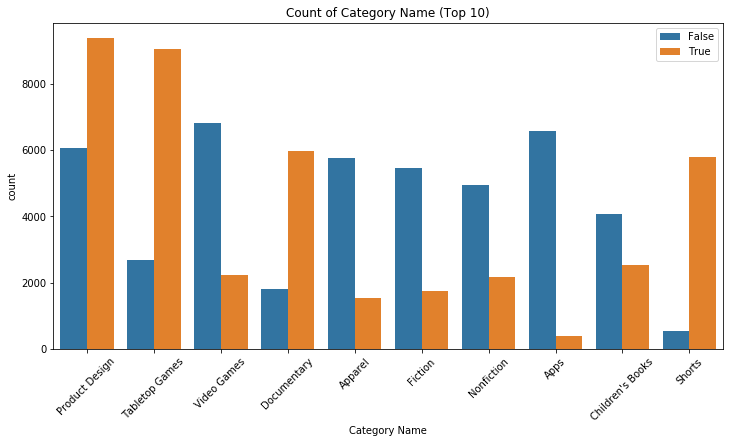

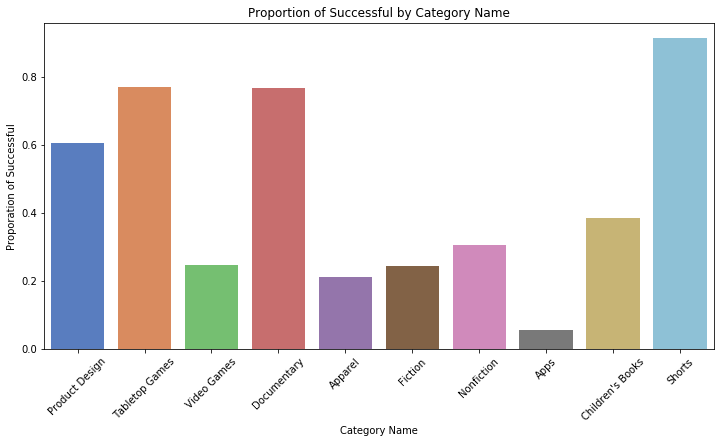

In [38]:
fig = plt.figure(figsize = (12, 6))
chart = sns.countplot(x = 'category_name', hue = 'outcome', data = cleaned_data, order=cleaned_data.category_name.value_counts().iloc[:10].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.legend(title ='')
plt.xlabel('Category Name')
plt.title("Count of Category Name (Top 10)")
plt.show()
#probability distribution
y = (cleaned_data['category_name'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['category_name'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=cleaned_data.category_name.value_counts().iloc[:10].index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Category Name')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Category Name')
plt.show()

There are very high variability between categories with Apps being extremely unsuccessful and shorts (clothing) being very successful.

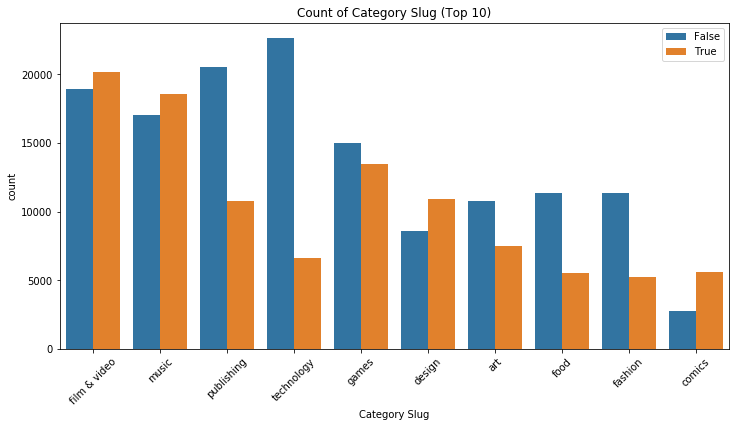

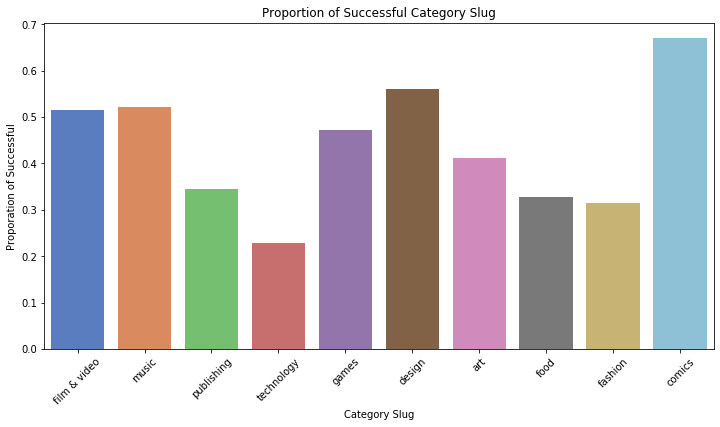

In [39]:
fig = plt.figure(figsize = (12, 6))
chart = sns.countplot(x = 'category_slug', hue = 'outcome', data = cleaned_data, order=cleaned_data.category_slug.value_counts().iloc[:10].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.legend(title ='')
plt.xlabel('Category Slug')
plt.title("Count of Category Slug (Top 10)")
plt.show()

#probability distribution
y = (cleaned_data['category_slug'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['category_slug'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=cleaned_data.category_slug.value_counts().iloc[:10].index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Category Slug')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful Category Slug')
plt.show()

Category slug may be more informative than category name due to the high variablity in the later column.

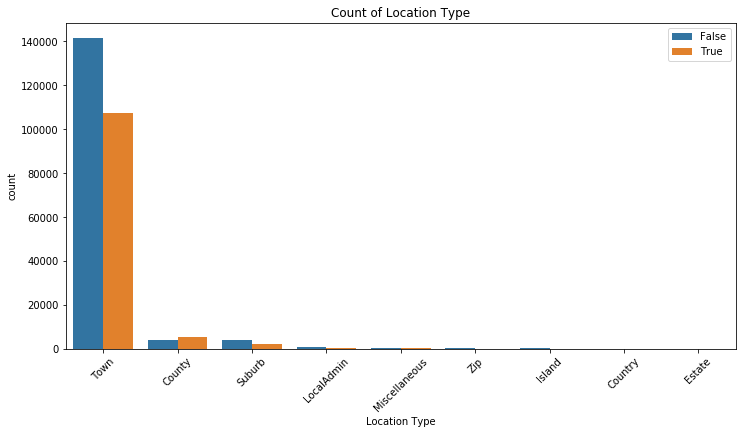

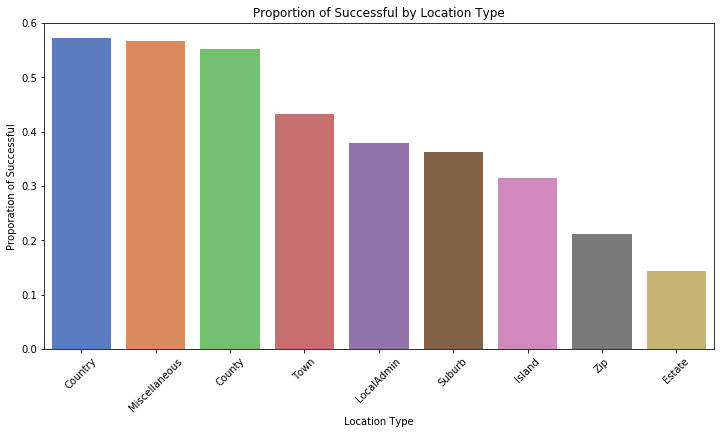

In [40]:
fig = plt.figure(figsize = (12, 6))
chart = sns.countplot(x = 'location_type', hue = 'outcome', data = cleaned_data, order=cleaned_data.location_type.value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.legend(title ='')
plt.xlabel('Location Type')
plt.title("Count of Location Type")
plt.show()

#probability distribution
y = (cleaned_data['location_type'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['location_type'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=y.index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('Location Type')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Location Type')
plt.show()

In [41]:
#too much concentration in town for the data to be useful?
print(cleaned_data.location_type.value_counts())

Town             248723
County             9464
Suburb             6276
LocalAdmin         1341
Miscellaneous       921
Zip                 567
Island              359
Country              21
Estate                7
Name: location_type, dtype: int64


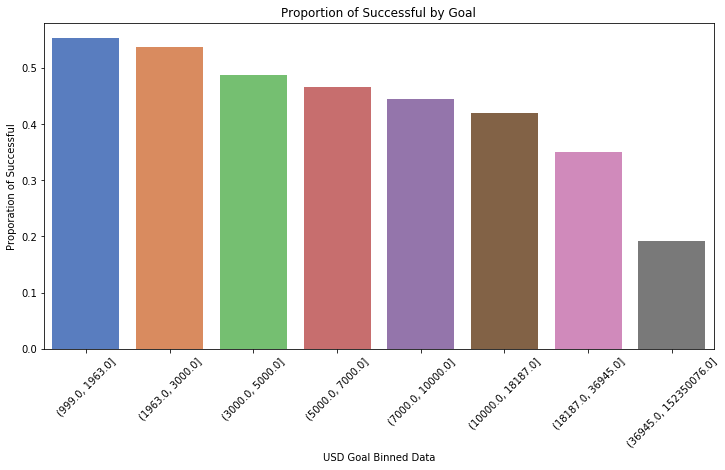

In [42]:
#binning the data to look at probabilities by goal USD
cleaned_data['qcut_goal'] = pd.qcut(cleaned_data['goal_USD'], q=8, precision = 0)
#probability distribution
y = (cleaned_data['qcut_goal'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['qcut_goal'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=y.index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('USD Goal Binned Data')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Goal')
plt.show()

As expected, probability declines with increasing USD goal amount.

(0.9999, 1.0001]    203039
(1.0001, 1.3]        20855
(1.3, 10.0]          19064
(0.755, 0.9999]      12613
(0.0, 0.755]         12108
Name: cut_static_rate, dtype: int64


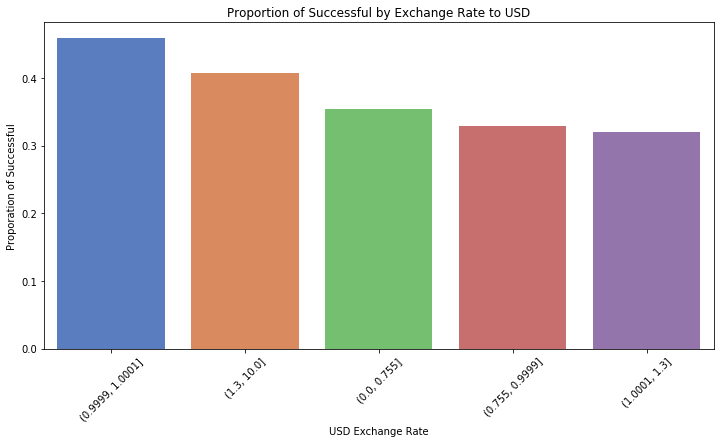

In [43]:
cleaned_data['cut_static_rate'] = pd.cut(cleaned_data['static_usd_rate'], [0,0.755, 0.9999,1.0001, 1.3, 10])
print(cleaned_data.cut_static_rate.value_counts())
#probability distribution
y = (cleaned_data['cut_static_rate'].loc[cleaned_data['outcome'] == True].value_counts())/(cleaned_data['cut_static_rate'].value_counts())
y = y.sort_values(ascending = False)
fig=plt.figure(figsize=(12,6))
ax = sns.barplot(x = y.index, y = y, order=y.index, palette = 'muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.xlabel('USD Exchange Rate')
plt.ylabel('Proporation of Successful')
plt.title('Proportion of Successful by Exchange Rate to USD')
plt.show()

Items listed in USD had the highest probability of success. There were mixed results for other currency, but the most valueable currency column did the second best. There will likely be heavy correlation with location_country. However, it won't be perfect as exchange rates change and not all US projects were listed in USD.